# RNSGA-II Searcher example

This is an example about how using RNSGAIISearcher for multi-objectives optimization.


## 1. Import modules and prepare data

In [1]:
from hypernets.core.random_state import set_random_state
set_random_state(1234)

from sklearn.preprocessing import LabelEncoder

from hypernets.utils import logging as hyn_logging
from hypernets.examples.plain_model import PlainModel, PlainSearchSpace
from hypernets.experiment import make_experiment

from hypernets.tabular import get_tool_box
from hypernets.tabular.datasets import dsutils
from hypernets.tabular.sklearn_ex import MultiLabelEncoder


hyn_logging.set_level(hyn_logging.WARN)

df = dsutils.load_bank().head(1000)
df['y'] = LabelEncoder().fit_transform(df['y'])
tb = get_tool_box(df)
df_train, df_test = tb.train_test_split(df, test_size=0.2, random_state=9527)

D:\miniconda3\envs\hypergbm-dev\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Run an experiment within NSGAIISearcher

In [2]:
import numpy as np

class CatPlainModel(PlainModel):

    def export_trial_configuration(self, trial):
        pass

    def __init__(self, searcher, dispatcher=None, callbacks=None, reward_metric=None, task=None,
                 discriminator=None):
        super(CatPlainModel, self).__init__(searcher, dispatcher=dispatcher, callbacks=callbacks,
                                            reward_metric=reward_metric, task=task)
        self.transformer = MultiLabelEncoder


experiment = make_experiment(CatPlainModel, df_train,
                             eval_data=df_test.copy(),
                             callbacks=[],
                             search_callbacks=[],
                             target='y',
                             searcher='rnsga2',  # available MOO searchers: moead, nsga2, rnsga2
                             searcher_options=dict(ref_point=np.array([0.3, 1 ]), weights=np.array([0.3, 1])),
                             reward_metric='logloss',
                             objectives=['elapsed'],
                             drift_detection_threshold=0.4,
                             drift_detection_min_features=3,
                             drift_detection_remove_size=0.5,
                             search_space=PlainSearchSpace(enable_dt=True, enable_lr=False, enable_nn=True))

estimators = experiment.run(max_trials=30)
estimators

[Pipeline(steps=[('data_clean',
                  DataCleanStep(data_cleaner_args={'correct_object_dtype': True,
                                                   'drop_columns': None,
                                                   'drop_constant_columns': True,
                                                   'drop_duplicated_columns': False,
                                                   'drop_idness_columns': True,
                                                   'drop_label_nan_rows': True,
                                                   'int_convert_to': 'float',
                                                   'nan_chars': None,
                                                   'reduce_mem_usage': False,
                                                   'reserve_columns': None},
                                name='data_clean')),
                 ('estimator',
                  PlainEstimator:MLPClassifier(activation='identity', learning_rate='invscaling', ma

## 3. Summary trails

In [3]:
df_trials = experiment.hyper_model_.history.to_df().copy().drop(['scores', 'reward'], axis=1)
df_trials[df_trials['non_dominated'] == True]

,trial_no,succeeded,elapsed,non_dominated,model_index,reward_logloss,reward_elapsed
1,2,True,1.551104,True,0.0,0.440664,1.551104
2,3,True,0.140767,True,1.0,0.538801,0.140767
6,7,True,0.009000,True,2.0,7.960230,0.009000
10,12,True,0.309148,True,3.0,0.480686,0.309148


## 4. Plot pareto font

We can pick model accord to Decision Maker's preferences from the pareto plot, the number in the figure indicates the index of pipeline models.


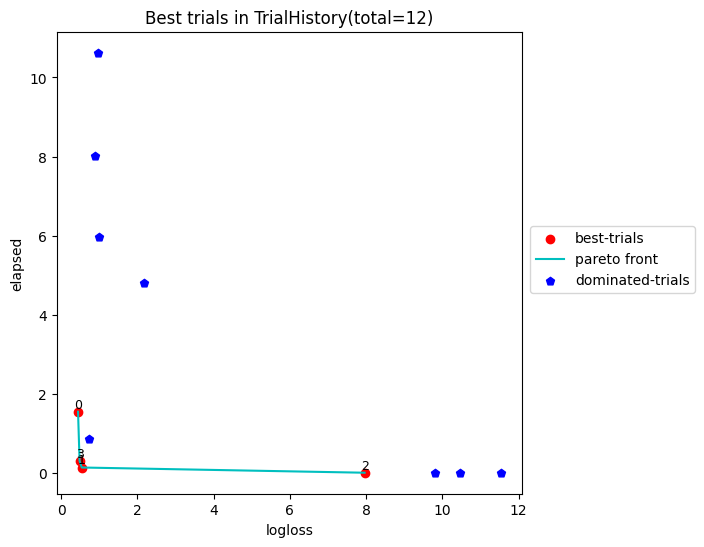

In [4]:
fig, ax  = experiment.hyper_model_.history.plot_best_trials()
fig.show()

## 5. Evaluate the selected model

In [5]:
print(f"Number of pipeline: {len(estimators)} ")

pipeline_model = estimators[0]  # selection the first pipeline model
X_test = df_test.copy()
y_test = X_test.pop('y')

preds = pipeline_model.predict(X_test)
proba = pipeline_model.predict_proba(X_test)

tb.metrics.calc_score(y_test, preds, proba, metrics=['auc', 'accuracy', 'f1', 'recall', 'precision'])

Number of pipeline: 4 


{'auc': 0.8139880952380952,
 'accuracy': 0.84,
 'f1': 0.0,
 'recall': 0.0,
 'precision': 0.0}